imported
loaded


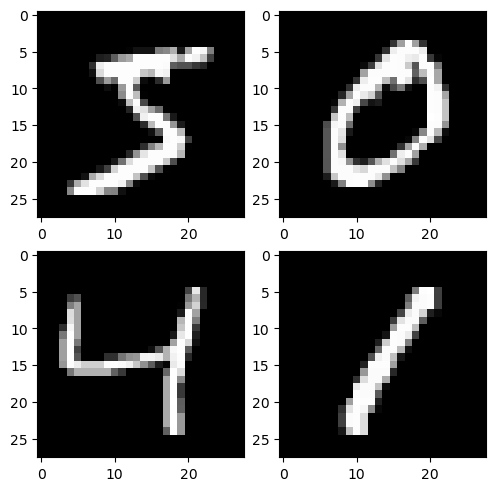

In [1]:
from glio.importsall import *
from glio.datasets import MNIST
print('imported')
dstrain, dstest = MNIST.get_mnist_classification()
print('loaded')
dstrain.preview()

In [2]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = ConvBlock(1, 64, 4, 1, act=nn.ReLU(), pool=nn.MaxPool2d(2,2))
        self.c2 = ConvBlock(64, 128, 3, 1, act=nn.ReLU(), pool=nn.MaxPool2d(2, 2))
        self.c3 = ConvBlock(128, 256, 2, 1, act=nn.ReLU(), pool=nn.MaxPool2d(2, 2))
        self.linear = LinearBlock(256*3*3, 10, act=nn.Softmax(dim=1), flatten=True)
    
    def forward(self,x):
        x = self.c1(x)
        x = self.c2(x)
        x = self.c3(x)
        x = self.linear(x)
        return x


print(f'{count_parameters(CNN()) = }')
gsummary(CNN(), (1, 1, 28,28))

count_parameters(CNN()) = 229322
path                                         module                                       input size               output size              params    buffers   
__main__.CNN/c1/0                            torch.nn.modules.conv.Conv2d                 (1, 1, 28, 28)           (1, 64, 29, 29)          1088      0         
__main__.CNN/c1/1                            torchzero.nn.layers.crop.SpatialReduceCrop   (1, 64, 29, 29)          (1, 64, 28, 28)          0         0         
__main__.CNN/c1/2                            torch.nn.modules.pooling.MaxPool2d           (1, 64, 28, 28)          (1, 64, 14, 14)          0         0         
__main__.CNN/c1/3                            torch.nn.modules.activation.ReLU             (1, 64, 14, 14)          (1, 64, 14, 14)          0         0         
__main__.CNN/c2/0                            torch.nn.modules.conv.Conv2d                 (1, 64, 14, 14)          (1, 128, 14, 14)         73856     0         
_

# SPSA
why does it go up

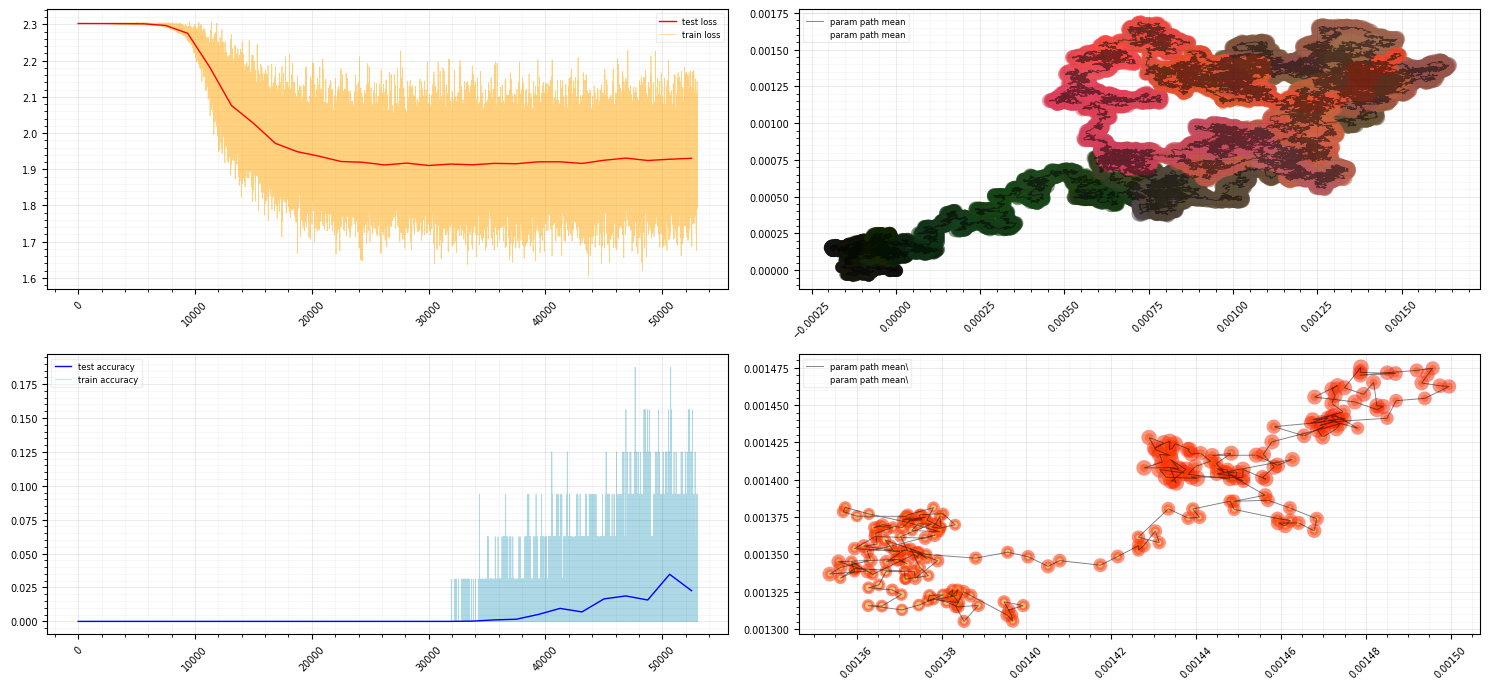

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉                                    | 29/100 | 51.34s/ops, elapsed: 23m:57s, rem: 01h:01m:36s | 

▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉            | 1407/1875 | 30.29ops/s, elapsed: 46.41s, rem: 15.48s | 
train loss:                              last = 1.957, min = 1.605, max = 2.307
test loss:                               last = 1.930, min = 1.910, max = 2.303
train accuracy:                          last = 0.031, min = 0.000, max = 0.188
test accuracy:                           last = 0.023, min = 0.000, max = 0.035

In [3]:
from torchzero.optim.zeroth_order import SPSA
with seeded_rng(): MODEL = CNN()
for p in MODEL.parameters(): p.data.zero_()
MAGN = 1e-5
LR = 1e-2
BATCH_SIZE = 32
N_EPOCHS = 100
LOSS_FN = nn.CrossEntropyLoss()
METRIC_STEP = 1

with seeded_rng():
    DLTRAIN = DataLoader(dstrain, BATCH_SIZE, shuffle=True, **seed0_kwargs)
    DLTEST = DataLoader(dstest, BATCH_SIZE, shuffle=False, **seed0_kwargs)

OPT = SPSA(MODEL.parameters(), lr = LR, magn=MAGN, max_diff=1e-6)
#SCHED = lr_scheduler.CosineAnnealingLR(OPT, N_EPOCHS)
SCHED = None

CALLBACKS = (LogLossCB(),

            SaveForwardChannelImagesCB(dstest[0][0].unsqueeze(0)),
            MetricAccuracyCB(),
            LogParamDistCB(METRIC_STEP),
            LogParamPathCB(METRIC_STEP),
            LogUpdateDistCB(METRIC_STEP),
            LogUpdatePathCB(METRIC_STEP),
            LogLastUpdatesAngleCB(METRIC_STEP),
            #Log_GradDist(METRIC_STEP),
            #Log_GradUpdateAngle(METRIC_STEP),
            #Log_GradPath(METRIC_STEP),
            #Log_LastGradsAngle(METRIC_STEP),
            LogTimeCB(),
            LogLRCB(),
            LogOptimizerParamCB('magn'),
            DisplayLoggerTableCB(),
            AccelerateCB("no"),
            PerformanceTweaksCB(True),
            SaveLastCB(),
            LivePlotCB(1000, plot_keys = ("4plotsplot","10metrics01"),path_keys=("4plotspath250",)),
            SimpleProgressBarCB(),
            GradientFreeWithZeroGradCB(),
            OneBatchClosureWithNoBackwardCB(),
              )
clean_mem()

# MODEL = gnn.LSUV(MODEL, DLTRAIN, max_iter=5)

LEARNER_NAME = f"SPSA lr{LR:.0e} magn{MAGN:.0e}"
learner = Learner(MODEL, LEARNER_NAME, CALLBACKS, loss_fn=LOSS_FN, optimizer=OPT, scheduler=SCHED, )
learner.fit(N_EPOCHS, DLTRAIN, DLTEST,test_on_interrupt=False)